In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-06 23:19:31.273918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-06 23:19:32.748680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 9200+70
end_idx = 9200+210
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(140, 96)

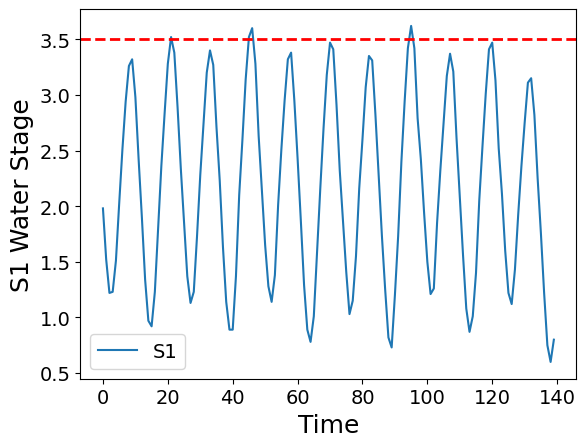

In [9]:
plt.plot(ws1[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [10]:
test_cov.shape

(19268, 96, 12)

### Get optimizable and not optimizable variables

In [11]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [12]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(140, 96, 7)
(94080,)


In [13]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(140, 96, 2)


In [14]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(140, 96, 3)


### GA

In [15]:
saved_model = load_model('../saved_models/WaLeF_gtn_p_1.h5', custom_objects={'GCNConv': GCNConv})
# load_model('cnn.h5', compile=False)

2023-08-06 23:19:43.874220: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:85:00.0, compute capability: 6.1


In [16]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [17]:
fitness_function = fitness_func

num_generations = 500
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [18]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [19]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-06 23:19:47.025743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 5ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 3ms/step
CPU time: 10241.832420737948 seconds


In [20]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

5/5 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.33491684 0.60176126 0.43218868 ... 0.96397282 0.47358406 0.39835243]
Fitness value of the best solution = 8.606788641929551e-05


### Post-processing

In [21]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

5/5 [==============================] - 0s 4ms/step


In [22]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

525


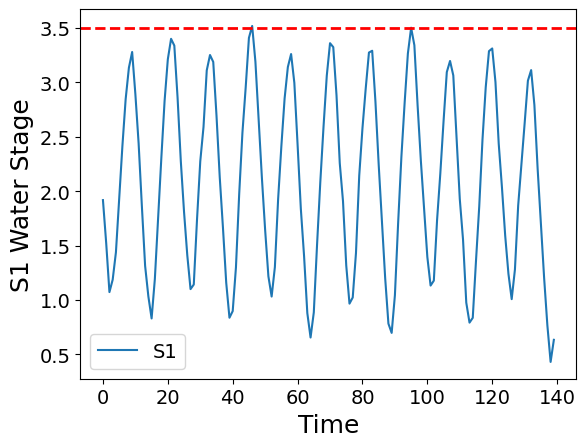

In [23]:
plt.plot(best_perf[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [24]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event3.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.334917,0.601761,0.432189,0.930525,0.092030,0.661151,0.235057,0.256664,0.019473,0.240313,...,0.353111,0.544759,0.205757,0.148264,0.180245,0.785236,0.950364,0.059142,0.175796,0.324801
1,0.439545,0.006835,0.075060,0.167341,0.881971,0.327119,0.738434,0.241353,0.998738,0.923309,...,0.244131,0.594537,0.041429,0.554196,0.811109,0.852784,0.742215,0.402476,0.357073,0.820606
2,0.688198,0.492907,0.581616,0.401938,0.088969,0.665297,0.420033,0.216407,0.882594,0.950371,...,0.110465,0.163893,0.025678,0.800146,0.811504,0.704963,0.094641,0.900977,0.350957,0.668761
3,0.650369,0.270844,0.752684,0.677797,0.027159,0.201377,0.298536,0.582228,0.349640,0.632486,...,0.805615,0.436713,0.388614,0.341130,0.199103,0.881170,0.342123,0.023774,0.055312,0.162929
4,0.652749,0.105180,0.260126,0.402963,0.123204,0.250955,0.344792,0.891806,0.806088,0.070838,...,0.889263,0.695327,0.559960,0.624212,0.607951,0.355105,0.042448,0.725578,0.511821,0.706245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.700928,0.942754,0.518326,0.554248,0.162123,0.396951,0.965271,0.498506,0.800352,0.704477,...,0.561260,0.493365,0.443700,0.020932,0.926868,0.194605,0.114702,0.692076,0.953230,0.047413
136,0.043703,0.042616,0.098477,0.400191,0.997431,0.031886,0.096395,0.275669,0.497011,0.063909,...,0.539891,0.576356,0.696413,0.229793,0.308493,0.036989,0.305650,0.045227,0.442403,0.510127
137,0.419465,0.172910,0.910351,0.577024,0.250841,0.502358,0.198896,0.720459,0.001920,0.567338,...,0.629130,0.514026,0.372364,0.286320,0.929409,0.582953,0.297651,0.797439,0.895738,0.745056
138,0.149841,0.304785,0.360257,0.742049,0.786755,0.570550,0.634171,0.256639,0.244112,0.220318,...,0.269435,0.901584,0.303465,0.418801,0.039908,0.326967,0.264646,0.781995,0.710604,0.778996


In [25]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event3.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.918408,1.919161,1.983666,2.087315,1.651964,1.625110,1.787907,1.824093,1.256599,1.664691,...,3.444049,3.679228,3.362777,3.397332,3.396448,3.609366,2.849434,2.834153,2.895380,3.155134
1,1.523544,1.528651,1.639200,1.741453,1.193322,1.387903,1.317786,1.342994,1.235578,1.552417,...,3.307301,3.512146,2.862562,2.918338,2.829757,3.073457,2.393700,2.454708,2.490825,2.695589
2,1.072889,1.277023,1.106535,1.273798,1.215846,1.133083,1.319106,1.430068,1.505073,1.725820,...,2.908055,3.063984,2.311855,2.370158,2.386416,2.511541,1.885988,2.015879,2.029991,2.161667
3,1.186776,1.120970,1.319591,1.389969,1.466761,1.421806,1.547388,1.657665,1.967221,1.917409,...,2.423625,2.515962,1.916540,1.980906,2.081033,2.169374,1.361794,1.270843,1.547895,1.633671
4,1.438724,1.371264,1.514675,1.587604,1.983962,2.072295,1.990152,2.153096,2.458246,2.384326,...,2.094863,2.181979,1.430115,1.627789,1.521603,1.637727,1.165084,1.347597,1.292498,1.438544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,1.699866,1.822359,1.798676,1.870120,1.325269,1.474154,1.424047,1.437814,0.902974,1.133110,...,3.139607,3.384780,3.239729,3.233581,3.272408,3.565894,2.796041,2.757790,2.823420,3.134757
136,1.202991,1.238443,1.302670,1.376794,0.842812,0.927278,0.998810,0.994330,0.616869,0.990716,...,3.123680,3.320602,2.834370,2.834570,2.815174,3.050765,2.220616,2.359860,2.178622,2.472516
137,0.767279,0.923171,0.891491,0.933056,0.584330,1.021240,0.740185,0.726462,0.793666,1.105033,...,2.793458,3.024506,2.261381,2.318648,2.310312,2.541839,1.827707,1.877575,1.928168,2.165435
138,0.430830,0.714877,0.490144,0.522292,0.656471,0.616232,0.733238,0.768549,1.225244,1.372081,...,2.353884,2.482079,1.829060,1.734780,1.914591,2.041566,1.316227,1.422386,1.377940,1.575503


In [26]:
Optimal_case = pd.read_csv("GA_results/best_performance_event3.csv")
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.918408,1.919161,1.983666,2.087315,1.651964,1.625110,1.787907,1.824093,1.256599,1.664691,...,3.444049,3.679228,3.362777,3.397332,3.396448,3.609366,2.849434,2.834153,2.895380,3.155134
1,1.523544,1.528651,1.639200,1.741453,1.193322,1.387903,1.317786,1.342994,1.235578,1.552417,...,3.307301,3.512145,2.862562,2.918338,2.829757,3.073457,2.393700,2.454708,2.490825,2.695589
2,1.072889,1.277023,1.106535,1.273798,1.215846,1.133083,1.319106,1.430068,1.505073,1.725820,...,2.908055,3.063984,2.311855,2.370158,2.386416,2.511541,1.885989,2.015879,2.029991,2.161667
3,1.186776,1.120970,1.319591,1.389969,1.466761,1.421806,1.547388,1.657665,1.967221,1.917409,...,2.423625,2.515962,1.916540,1.980906,2.081034,2.169374,1.361794,1.270843,1.547895,1.633671
4,1.438724,1.371264,1.514675,1.587604,1.983962,2.072295,1.990152,2.153096,2.458246,2.384326,...,2.094863,2.181979,1.430115,1.627790,1.521603,1.637727,1.165084,1.347598,1.292498,1.438544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,1.699866,1.822359,1.798676,1.870120,1.325269,1.474153,1.424047,1.437814,0.902974,1.133110,...,3.139607,3.384780,3.239729,3.233581,3.272408,3.565894,2.796041,2.757790,2.823420,3.134757
136,1.202991,1.238442,1.302671,1.376794,0.842812,0.927278,0.998810,0.994330,0.616869,0.990716,...,3.123680,3.320602,2.834370,2.834570,2.815174,3.050765,2.220616,2.359860,2.178622,2.472516
137,0.767279,0.923171,0.891491,0.933056,0.584330,1.021240,0.740186,0.726462,0.793666,1.105033,...,2.793458,3.024506,2.261381,2.318648,2.310312,2.541839,1.827707,1.877575,1.928168,2.165435
138,0.430830,0.714877,0.490144,0.522292,0.656471,0.616232,0.733238,0.768549,1.225244,1.372081,...,2.353884,2.482079,1.829060,1.734780,1.914591,2.041566,1.316227,1.422386,1.377940,1.575503


In [27]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 525, areas: 52.26626970000002
time steps: 0, areas: 0


In [28]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

5/5 [==============================] - 0s 4ms/step
time steps: 655, areas: 71.93803930282593
time steps: 0, areas: 0
